In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib
from matplotlib import pyplot as plt

img_name = 'img/lena_std.tif'
img = cv.imread(img_name, cv.IMREAD_GRAYSCALE)

Text(0.5, 1.0, 'image gray level histogram(normalized)')

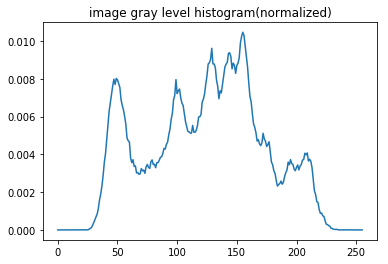

In [2]:
hist = cv.calcHist([img], [0], None, [256], [0,256])
hist_normal = cv.normalize(hist.ravel(), None, norm_type=cv.NORM_L1).ravel()
plt.plot(hist_normal)
plt.title('image gray level histogram(normalized)')

In [3]:
def max_entropy(hist_normal):
    """
    Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
    Kapur J.N., Sahoo P.K., and Wong A.K.C. (1985) "A New Method for Gray-Level Picture Thresholding Using the Entropy
    of the Histogram", Graphical Models and Image Processing, 29(3): 273-285
    参考：https://github.com/zenr/ippy/blob/master/segmentation/max_entropy.py
    Params:
        hist_normal [np.array]: 归一化后的图像灰度直方图。
    Return:
        threshold [int]: threshold
    """

    # calculate normalized CDF (cumulative density function)
    cdf_normal = hist_normal.cumsum()

    valid_range = np.nonzero(hist_normal)[0]
    s_range = hist_normal[hist_normal != 0]
    H_s_cum = -np.cumsum(s_range * np.log(s_range))

    H_n = H_s_cum[-1]

    max_ent, threshold = 0, 0
    ents = []
    for i in range(len(H_s_cum) - 1): # 忽略最后一个非零点，防止P_s为1导致(1 - P_s)为0
        s = valid_range[i]
        P_s = cdf_normal[s]
        H_s = H_s_cum[i]
        total_ent = np.log(P_s * (1 - P_s)) + H_s/P_s + (H_n - H_s)/(1 - P_s)
        
        ents.append(total_ent)
        # find max
        if total_ent > max_ent:
            max_ent, threshold = total_ent, s

    return threshold, max_ent, valid_range, ents

计算出阈值为122


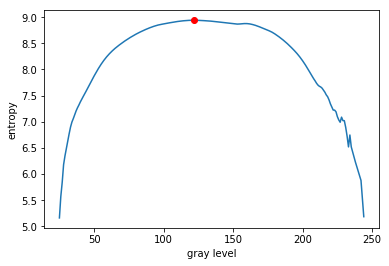

In [4]:
threshold, max_ent, valid_range, ents = max_entropy(hist_normal)
plt.plot(valid_range[:-1], ents)
plt.plot(threshold, max_ent, 'ro')
plt.xlabel('gray level')
plt.ylabel('entropy')
print(f'计算出阈值为{threshold}')

由一维最大熵分割算法计算出的图像img/lena_std.tif的阈值为: 122


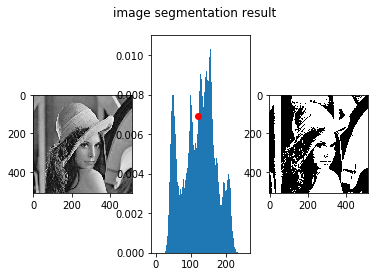

In [5]:
_, thr_img = cv.threshold(img, threshold, 255, cv.THRESH_BINARY)
fig, ax_list = plt.subplots(1, 3)
fig.suptitle('image segmentation result')
ax_list[0].imshow(img, 'gray')

ax_list[1].hist(img.ravel(), 256, [0,256], density=True)
ax_list[1].plot(threshold, hist_normal[threshold], 'ro')

ax_list[2].imshow(thr_img, 'gray')

print(f'由一维最大熵分割算法计算出的图像{img_name}的阈值为: {threshold}')
plt.show()

lap_img max value is 181


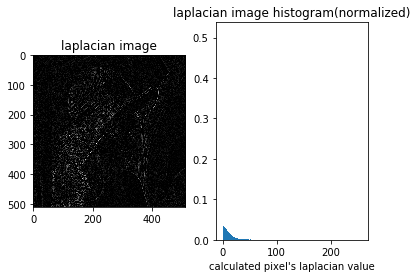

In [6]:
lap_img = abs(cv.Laplacian(img, -1))

plt.subplot(1, 2, 1)
plt.imshow(lap_img, 'gray')
plt.title('laplacian image')
plt.subplot(1, 2, 2)
plt.hist(lap_img.ravel(), 256, [0,256], density=True)
plt.title('laplacian image histogram(normalized)')
plt.xlabel("calculated pixel's laplacian value")
print(f'lap_img max value is {np.max(lap_img)}')

选取阈值36.2来对lap_img进行阈值处理，得到二值图像mask。


Text(0.5, 1.0, 'border_mask binary image')

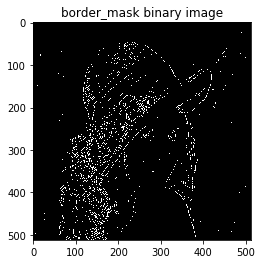

In [7]:
T = np.max(lap_img) * 0.2
_, border_mask = cv.threshold(lap_img, T, 255, cv.THRESH_BINARY)
print(f'选取阈值{T}来对lap_img进行阈值处理，得到二值图像mask。')
plt.imshow(border_mask, 'gray')
plt.title('border_mask binary image')

仅统计border_mask二值图像中亮的位置的像素，得到灰度直方图。然后使用最大熵算法来计算阈值
经使用边缘信息改进后再次计算阈值为: 122


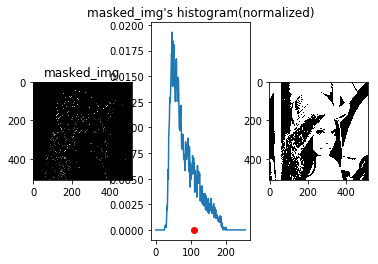

In [8]:
masked_img = cv.bitwise_and(img, img, mask=border_mask)
masked_img_hist = cv.calcHist([img], [0], border_mask, [256], [0,256])
masked_img_hist_normal = cv.normalize(masked_img_hist.ravel(), None, norm_type=cv.NORM_L1).ravel()
print('仅统计border_mask二值图像中亮的位置的像素，得到灰度直方图。然后使用最大熵算法来计算阈值')
th2, max_ent, valid_range, ents = max_entropy(masked_img_hist_normal)
_, thr_img = cv.threshold(img, th2, 255, cv.THRESH_BINARY)

plt.subplot(1, 3, 1)
plt.imshow(masked_img, 'gray')
plt.title('masked_img')

plt.subplot(1, 3, 2)
plt.plot(masked_img_hist_normal)
plt.plot(th2, 0, 'ro')
plt.title("masked_img's histogram(normalized)")

plt.subplot(1, 3, 3)
plt.imshow(thr_img, 'gray')

print(f'经使用边缘信息改进后再次计算阈值为: {threshold}')